# **Project - Probabilistic Graphical Model - K-means on PCA:**

**Rania Bennani - Raphaël Razafindralambo - Esteban Christiann**

This project explores the impact of various initialization methods and datasets on the performance of the K-Means clustering algorithm with the integration of Principal Component Analysis (PCA).

**Guide to the Notebook:**
1. Useful Libraries:

2. K-Means Initialization Function:
Explore different initialization methods, including random, K-Means++, and PCA-based methods.

3. Datasets:
Examine three datasets – Gaussian Mixture Model (GMM), moons, and MNIST – along with ground truth labels for comprehensive evaluation.

4. Generic Function of K-Means Algorithm and PCA Algorithm:
Computation of the core function: K-Means clustering algorithm, incorporating various initialization methods.

5. Metrics Used:
Compute performance metrics like confusion matrix, accuracy, sensitivity, recall, precision, F1 score, and distortion.

6. Implementation/Run of Scenarios:
Witness the practical implementation and outcomes of diverse scenarios under different initialization methods and datasets.

7. Supplementary Section:
Explore additional datasets not included in the final report due to limited contributions.

## **Useful Libraires**
In this section, we import essential libraries required for the implementation of the PCA in K-Means project. These libraries provide the necessary tools and functions to carry out various tasks efficiently. We managed to use the less libraries as possible and to code the main algorithms from scratch.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import time
import scipy
from scipy.optimize import linear_sum_assignment
from scipy.signal import find_peaks
from sklearn import datasets
from scipy.stats import multivariate_normal
import sys

In [ ]:
sys.setrecursionlimit(10**5)

## **K-means Initialization functions :**
This part introduces a crucial aspect of K-Means clustering, the initialization function. Different methods are explored, including random initialization, K-Means++, k-means-rand, k-means-k++, PCA-part, PCA guided search, and PCA continuous. Each method plays a distinct role in influencing the convergence and performance of the K-Means algorithm.

In [ ]:
#Random initialization:

def random_init(X, k):
    """
    Inputs:
    - X: Input data of shape (n_samples, n_features).
    - k: Number of clusters that should be formed.
    - random_state: An integer seed for the random number generator or a numpy RandomState object.

    Outputs:
    - centroids: Initial centroids randomly selected.
    """
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    return centroids

In [ ]:
#KR (Kaufman and Rousseeuw) Method:
def kr_init(X,k):
  """
    Inputs:
    - X: Input data of shape (n_samples, n_features).
    - k: number of cluster that should be formed

    Outputs:
    - centroids: initial centroids selected using KR algorithm
    """
  centroids = [X[np.argmin(np.sum(np.linalg.norm(X - X[0], axis=1)))]]  # Initialization for k=1

  for _ in range(1, k):
      # Exclude previously chosen centroids
      X_excluded = X[np.setdiff1d(np.arange(X.shape[0]), [np.where(np.all(np.isclose(c, X), axis=1))[0][0] for c in centroids])]

      # Calculate dissimilarity for each point to existing centroids
      dissimilarities = np.sum(np.maximum(
          np.linalg.norm(X_excluded[:, np.newaxis] - np.array(centroids), axis=2) -
          np.linalg.norm(X_excluded[:, np.newaxis] - X_excluded[:, np.newaxis, :], axis=2), 0
      ), axis=1)

      new_centroid = X_excluded[np.argmax(dissimilarities)]
      centroids.append(new_centroid)

  return np.array(centroids)

In [ ]:
#KKZ (Ioannis Katsavounidis, C.-C. Jay Kuo, and Ben Zhang) Method:

def kkz_init(X,k):
  """
    Inputs:
    - X: Input data of shape (n_samples, n_features).
    - k: number of cluster that should be formed

    Outputs:
    - centroids: initial centroids selected using KKZ algorithm
    """
  centroids = [X[np.argmax(np.linalg.norm(X, axis=1))]]  # Initialization for k=1

  for _ in range(1, k):
      # Exclude previously chosen centroids
      X_excluded = X[np.setdiff1d(np.arange(X.shape[0]), [np.where(np.all(np.isclose(c, X), axis=1))[0][0] for c in centroids])]

      # Find the farthest point from existing centroids
      distances = np.array([np.min(np.linalg.norm(x - np.array(centroids))) for x in X_excluded])
      new_centroid = X_excluded[np.argmax(distances)]

      centroids.append(new_centroid)

  return np.array(centroids)

In [ ]:
#K-means++ Method:
def kmeanspp_init(X, k):
    """
    Inputs:
    - X: Input data of shape (n_samples, n_features).
    - K: number of cluster that should be formed

    Outputs:
    - centroids: initial centroids selected by kmeans++
    """
    n = X.shape[0]
    centroids = np.empty((k, X.shape[1]))

    # Randomly choose a first centroid
    first_centroid_idx = np.random.randint(0, n)
    centroids[0] = X[first_centroid_idx]

    # Calculate the first distance
    distances = np.linalg.norm(X - centroids[0], axis=1)

    for i in range(1, k):
        #In this loop, we have to choose the new centroid with a probabilities that is proportional to the squared distance
        probabilities = distances ** 2
        probabilities /= probabilities.sum()
        next_centroid_idx = np.random.choice(n, p=probabilities)
        centroids[i] = X[next_centroid_idx]

        # Update distances
        new_distances = np.linalg.norm(X - centroids[i], axis=1)
        distances = np.minimum(distances, new_distances)

    return centroids

In [ ]:
#HAC Method:

def delta(s_1,s_2,n_1,n_2):
    n_12 = np.sqrt(n_1/(n_2*(n_1+n_2)))
    n_21 = np.sqrt(n_2/(n_1*(n_1+n_2)))
    w = n_21*s_1 - n_12*s_2
    return w@w


def HAC_init(X, K, delta=delta):

    n_samples = X.shape[0]

    # Initialization of thee clusters. Here, we first consider that each sample is a cluster itself:
    clusters = {i: [i] for i in range(n_samples)}
    sums = {i: X[i] for i in range(n_samples)}
    # Vecteur de calssification
    ns = {i: 1 for i in range(n_samples)}

    # Initialization of distances' matrix:
    distance_matrix = np.full((n_samples, n_samples), float('inf'))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            distance_matrix[i, j] = delta(sums[i],sums[j],1,1)  # Utilisation des points en tant que clusters
            distance_matrix[j, i] = distance_matrix[i, j]

    while len(clusters) > K:

        # Find the pair of clusters to merge
        i, j = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

        # Clusters' merge
        sums[i] = sums[i] + sums[j]
        ns[i] = ns[i] + ns[j]
        clusters[i] = clusters[i] + clusters[j]

        del clusters[j]
        del sums[j]
        del ns[j]

        #Update the matrrix of distances for the new cluster i
        for k in clusters:
            if k != i:
                d = delta(sums[i],sums[k],ns[i],ns[k])
                distance_matrix[i, k] = d
                distance_matrix[k, i] = d

        # Each merged cluster in now considered as "infinity"
        distance_matrix[:, j] = float('inf')
        distance_matrix[j, :] = float('inf')

    # Calculate the centroïdes of the final clusterrs
    centroids = np.array([np.mean(X[cluster], axis=0) for cluster in clusters.values()])

    return centroids

In [ ]:
#Continuous Kmeans Method:

#We first define few functions that we will use in the principal continuous kmean method function:
def connected_components(W):
    '''
    Returns the list of connected components of a graph given as an adjency matrix
    '''

    print('Computing connected components')
    n = W.shape[0]
    seen = [False for _ in range(n)]

    def dfs(u, component):
        if seen[u]:
            return
        seen[u] = True
        component.append(u)
        for v in range(n):
            if W[u, v] > 0:
                dfs(v, component)

    components = []
    for u in range(n):
        if not seen[u]:
            component = []
            dfs(u, component)
            components.append(component)

    return components


def spectral_ordering(W):
    '''
    Returns the spectral ordering: a permutation that we may apply to columns and
    rows of W to recover a block diagonal matrix. Useful for linearized cluster
    assignment. See https://doi.org/10.1145/1015330.1015407
    '''
    components = connected_components(W)
    print('Computing spectral ordering')

    ordering = []
    for component in components: # For each connected component
        W_component = W[component, :][:, component]

        if len(component) > 1:
            # Construct the Laplaciann of the component
            L = np.diag(W_component.sum(axis=0)) - W_component

            # Compute its second smallest eigenvalue (Fiedler vector)
            _, eig_vec = np.linalg.eigh(L)
            fiedler_vector = eig_vec[:, [1]]

            # Order vertices according to their projection on the Fiedler vector
            component_ordering = (L @ fiedler_vector).flatten().argsort()
            component_ordering = [component[i] for i in component_ordering]
            ordering.extend(component_ordering)
        else:
            ordering.extend(component)

    print('Spectral ordering computed')
    return ordering

def linearized_cluster_assignment(W, K, plots=False):
    '''
    Recover a clustering from a similarity matrix W using linearized
    cluster assignment: https://doi.org/10.1145/1015330.1015407

    The algorithm first reorder rows and columns of W to recover a block
    diagonal structure. Then, it looks for the positions of the block's corners
    by finding valleys points of the 1-d quantity rho

    W: nxn similarity matrix
    K: number of clusters
    plot: plot the similarity matrix before and after spectral reordering

    Returns an array of length n containing the cluster assignments
    '''
    n = W.shape[0]
    m = 1 + n // K # expected cluster size

    # First recover the ordering of rows and columns to apply to get
    # the block diagonal structure
    sp_order = spectral_ordering(W)

    # rho[i] is somewhat the sum of elements of W along the i-th antidiagonal
    # of W (after reordering rows and columns). Corners of the blocks on the
    # diagonal correspond to valleys points of rho
    rho = []
    for i in range(n):
        rho_i = 0
        for j in range(1, m+1):
            if i - j >= 0:
                if i + j < n:
                    rho_i += 0.5 * W[sp_order[i-j], sp_order[i+j]]
                if i + j + 1 < n:
                    rho_i += 0.25 * W[sp_order[i-j], sp_order[i+j+1]]
                if i + j - 1 < n:
                    rho_i += 0.25 * W[sp_order[i-j], sp_order[i+j-1]]
        rho.append(rho_i)
    rho = np.array(rho)

    # Smoothing
    rho = np.convolve(rho, [0.1, 0.2, 0.4, 0.2, 0.1], mode='same')

    print(f'Initializing valley point detection...')

    # The valley point detection algorithm works in two steps:
    l, r = 0, 1
    peaks = find_peaks(-rho, prominence=r)[0]

    # 1. find an upper bound on the prominence needed to detect at most K-1 valleys
    while len(peaks) > K-1:
        r *= 2
        peaks = find_peaks(-rho, prominence=r)[0]

    # 2. find the right prominence that detects K-1 valleys using binary search
    while r - l > 10**-6:
        mid = (l+r)/2
        peaks = find_peaks(-rho, prominence=mid)[0]
        print(f'Current prominence {mid}, {len(peaks)} peaks')

        if len(peaks) == K-1:
            break
        elif len(peaks) > K-1:
            l = mid
        else:
            r = mid

    if plots:
        fig = plt.figure()
        ax= fig.add_subplot()
        ax.plot(rho, label='rho')
        fig.legend()
        fig.show()

        fig = plt.figure()
        ax= fig.add_subplot()
        ax.imshow(W, vmin=0, vmax=1)
        fig.show()

        fig = plt.figure()
        ax= fig.add_subplot()
        ax.imshow(W[:, sp_order][sp_order, :], vmin=0, vmax=1)
        fig.show()

    if len(peaks) == K-1:
        print(f'Found K-1 valleys {peaks}')
    else:
        raise ValueError("Cannot find K-1 valleys...")

    # Convert valley point positions to cluster assignments
    seps = [0] + peaks.tolist() + [n]
    cluster = np.zeros(n, dtype=np.int32)
    for k in range(K):
        cluster[sp_order[seps[k] : seps[k+1]]] = k
    return cluster

def continuous_kmeans_init(X, K, minP=0.5, plots=False):
    '''
    Computes a clustering associated to the solution of the continuous K-means objective
    https://doi.org/10.1145/1015330.1015408

    X: the nxd data matrix
    K: the number of clusters
    minP: min non-zero similarity in the similarity matrix

    Returns an array of length n containing the cluster assignments
    '''
    n = X.shape[0]

    # Center the data
    Y = X - X.mean(axis=0, keepdims=True)

    # The solution of the continuous K-means objective is given by the first
    # columns of matrix U
    U, S, V = svd(Y)

    # Construct the similarity matrix ee^T / n + sum_{k=1}^{K-1} u_k u_k^T
    C = np.ones((n, n))/n
    for k in range(K-1):
        u_k = U[:, [k]]
        C += u_k @ u_k.T

    # Clip, normalize and remove edges if the similarity is too low
    C = C.clip(0)
    sq_C = np.sqrt(np.diag(C))
    C = C / (sq_C[None, :] * sq_C[:, None])
    C[C < minP] = 0

    # Recovers the block diagonal structure of C (via spectral ordering)
    # and the block boundaries (via valley detection) to get a clustering
    clusters = linearized_cluster_assignment(C, K, plots=plots)
    centroids = np.array([X[clusters == i].mean(axis=0) for i in range(K)])
    return centroids

In [ ]:
#PCA-part Method:
def PCA_part_init(X, K):

    '''
    PCA-part initialization. At each iteration, split the largest variance cluster
    along its principal direction.
    https://doi.org/10.3233/IDA-2007-11402
    '''

    n = X.shape[0]
    cluster = np.zeros(n, dtype=np.int32)

    for k in range(1, K):
        # Find the maximum variance cluster
        max_k2 = 0
        max_var = 0
        for k2 in range(k):
            X_k2 = X[cluster == k2, :]
            m_k2 = X_k2.mean(axis=0, keepdims=True)
            var_k2 = np.sum((X_k2 - m_k2)**2)
            if var_k2 > max_var:
                max_var, max_k2 = var_k2, k2
        k2 = max_k2
        X_k2 = X[cluster == k2, :]
        m_k2 = X_k2.mean(axis=0, keepdims=True)

        # Compute the principal component
        U, S, V = svd(X_k2 - m_k2)
        pc1 = (U @ np.diag(S))[:, 0]

        # Split the cluster
        k2_indices = np.flatnonzero(cluster == k2)
        cluster[k2_indices[pc1 > 0]] = k

    centroids = np.array([X[cluster == i].mean(axis=0) for i in range(K)])
    return centroids


In [ ]:
#PCA guided search Method:

def PCA_guided_search_init(X,k):
    """
    Inputs:
    - X: Input data of shape (n_samples, n_features).
    - k: number of cluster that should be formed

    Outputs:
    - centroids: initial centroids selected with PCA-guided search
    """
    X_pca = pca(X, k-1)
    labels,_ = kmeans(X_pca,k,"random")
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return centroids

## **Datasets**
Here, we present three diverse datasets, each designed to test the effectiveness of the PCA in K-Means clustering. The datasets include a three-cluster Gaussian Mixture Model (GMM), moon-shaped clusters (moons), and the MNIST dataset. Additionally, ground truth labels (y_label) for each dataset are provided, facilitating the evaluation of clustering results.

In [ ]:
#Dataset 1 (three-cluster gaussian mixture model):
def sample_discrete(n_samples,x,probs,random_state=42):
    rng = np.random.default_rng(random_state)
    U = rng.uniform(0, 1, n_samples)
    X = np.zeros(n_samples)
    sk = 0
    for k,xk in enumerate(x):
        skk = np.sum(probs[:k+1])
        X += xk * ((sk < U) & (U <= skk))
        sk = skk
    return X

def sample_GMM(n_samples,n_features, means,covs,probs, random_state=42):
    rng = np.random.default_rng(random_state)
    y = []
    X = []
    discr = sample_discrete(n_samples,np.arange(len(probs)),probs,random_state)
    for x in discr:
        X.append(rng.multivariate_normal(means[int(x)], covs[int(x)]))
        y.append(int(x))

    X = np.array(X)
    y = np.array(y)
    return X,y

def sample_gmm_3_clusters(n_samples, random_state=42):
    means = [[0, 0], [12, 12], [-7, -7]]
    covs = [np.eye(2), np.eye(2) * 2, np.eye(2) / 2]
    probs = [0.4, 0.3, 0.3]
    return sample_GMM(n_samples, 2, means, covs, probs, random_state)

In [ ]:
#Dataset 2 (moon-shaped cluster):
def sample_moons(n_samples, noise=0.1, random_state=42):
    rng = np.random.default_rng(random_state)
    x = np.linspace(0, np.pi, n_samples // 2)

    outer_circle_x = np.cos(x)
    outer_circle_y = np.sin(x)
    inner_circle_x = 1 - np.cos(x)
    inner_circle_y = 1 - np.sin(x) - .5

    X = np.concatenate([np.column_stack([outer_circle_x, outer_circle_y]),
                        np.column_stack([inner_circle_x, inner_circle_y])])
    y = np.concatenate([np.zeros(n_samples // 2), np.ones(n_samples // 2)])

    # Ajouter du bruit
    X += rng.normal(scale=noise, size=X.shape)

    return X, y

In [ ]:
#Dataset 3 (rescaled MNIST dataset):
def sample_mnist():
    return datasets.load_digits(return_X_y=True) #Smaller MNIST used in order to run the k-means algorithm on the entire dataset

## **Generic Function of K-Means Algorithm and PCA Algorithm**
This section introduces a generic function that encapsulates the core logic of the K-Means clustering algorithm. The function takes into account different initialization methods discussed earlier. Additionally, the PCA algorithm is presented as a separate entity, providing dimensionality reduction capabilities crucial for enhancing the performance of K-Means.

In [ ]:
def kmeans(X, k, init="random", epsilon=1e-4):

    init_func = {
      "random":random_init,
      "kmeans++":kmeanspp_init,
      "HAC":HAC_init,
      "PCA guided search":PCA_guided_search_init,
      "KR":kr_init,
      "KKZ":kkz_init,
      "PCA part":PCA_part_init,
      "continuous kmeans": continuous_kmeans_init
    }
    # Centroids initialization using one of the eight initialization function described previously
    centroids = init_func[init](X,k)
    while True:
        # Affect each point to its nearest centroid."
        labels = np.argmin(np.linalg.norm(X - centroids[:, np.newaxis], axis=2), axis=0)
        # Update centrroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Stopping criterion of our While loop
        if np.linalg.norm(new_centroids - centroids) / k < epsilon:
            break

        centroids = new_centroids

    return labels, centroids


In [ ]:
def pca(X, num_components =1):
    mean_X = np.mean(X, axis=0)
    X_normalized = X - mean_X #data normalization
    cov_matrix = np.cov(X_normalized, rowvar=False) #Calculate the covariance matrix of the normalized data
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    #PCA
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    selected_eigenvectors = eigenvectors[:, :num_components]

    X_pca = np.dot(X_normalized, selected_eigenvectors) #Project the data onto the selected principal components
    return X_pca

def svd(M):
    U, S, V_T = np.linalg.svd(M, full_matrices=False)
    V = V_T.T
    return U, S, V


## **Metrics used:**
Here, we delve into the various metrics employed to assess the performance of the K-Means clustering algorithm. Metrics such as confusion matrix, accuracy, sensitivity, recall, precision, F1 score, and distortion are utilized. These metrics offer a comprehensive evaluation of clustering results, highlighting both global and local aspects of model performance.

In [ ]:
# Confusion Matrix:

def confusion_matrix(y_true, y_pred):
    """
    Inputs:
      - y_true: True labels.
      - y_pred: Predicted labels.

    Outputs:
      - conf_mat: Confusion matrix.
    """
    K = len(np.unique(np.concatenate([y_true, y_pred])))
    cost_matrix = np.zeros((K, K))

    # Create a cost matrix based on the frequency of matches
    for i in range(K):
        for j in range(K):
            cost_matrix[i, j] = -np.sum((y_true == i) & (y_pred == j))

    # Find the optimal alignment using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Realign y_pred based on this alignment
    aligned_pred = np.zeros_like(y_pred)
    for i, j in zip(row_ind, col_ind):
        aligned_pred[y_pred == j] = i

    classes = np.arange(K)
    conf_mat = np.array([[np.sum((y_true == i) & (aligned_pred == j)) for j in classes] for i in classes])
    return conf_mat

In [ ]:
#Accuracy:
def accuracy(y_true, y_pred):
    """
    Inputs:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Outputs:
    - acc: Accuracy.
    """
    conf_mat = confusion_matrix(y_true, y_pred)
    correct = np.sum(np.diag(conf_mat))
    total = np.sum(conf_mat)
    acc = correct / total
    return acc

In [ ]:
#Specificity:
def specificity(y_true, y_pred):
    """
    Inputs:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Outputs:
    - spec: Specificity.
    """
    conf_mat = confusion_matrix(y_true, y_pred)
    true_negatives = np.sum(np.diag(conf_mat)) - np.sum(conf_mat, axis=0)
    negatives = np.sum(conf_mat, axis=1) - np.sum(np.diag(conf_mat))
    spec = np.sum(true_negatives / negatives) / len(np.unique(y_true))
    return spec

In [ ]:
#Recall:
def recall(y_true, y_pred):
    """
    Inputs:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Outputs:
    - rec: Recall.
    """
    conf_mat = confusion_matrix(y_true, y_pred)
    true_positives = np.diag(conf_mat)
    actual_positives = np.sum(conf_mat, axis=1)
    rec = np.sum(true_positives / actual_positives) / len(np.unique(y_true))
    return rec

In [ ]:
#Precison:
def precision(y_true, y_pred):
    """
    Inputs:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Outputs:
    - prec: Precision.
    """
    conf_mat = confusion_matrix(y_true, y_pred)
    true_positives = np.diag(conf_mat)
    predicted_positives = np.sum(conf_mat, axis=0)
    prec = np.sum(true_positives / predicted_positives) / len(np.unique(y_true))
    return prec


In [ ]:
#F-1 score:
def f1_score(y_true, y_pred):
    """
    Inputs:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Outputs:
    - f1: F1 score.
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = 2 * (prec * rec) / (prec + rec)
    return f1

In [ ]:
#Distorsion:
def distortion(X, centroids, labels):
    """
    Inputs:
    - X: Data points.
    - centroids: Cluster centroids.
    - labels: Cluster labels for each point.

    Outputs:
    - dist: Distortion.
    """
    dist = np.sum([np.sum(np.linalg.norm(X[labels == i] - centroids[i], axis=1)**2) for i in np.unique(labels)])
    return dist

## **Implementation of the scenarios:**
The final section demonstrates the practical implementation and execution of different scenarios using the K-Means algorithm on the specified datasets. Each scenario provides insights into the behavior and outcomes of the algorithm under different initialization methods and datasets. This comprehensive analysis aims to enhance understanding and facilitate informed decision-making in real-world applications.

In [ ]:
def scenarios(X,y,k,random_inits,deterministic_inits,n_runs):
    results = {}
    random_init_distortions = {init: [] for init in random_inits}
    # Testing random initializations
    for init in random_inits:
        distortions = []
        print("Init: ", init)
        min_distortion = float('inf')
        best_metrics = None
        total_time = 0
        for _ in range(n_runs):
            start_time = time.time()
            y_pred, centroids = kmeans(X, len(np.unique(y)), init)
            dist = distortion(X, centroids, y_pred)
            total_time += time.time() - start_time
            distortions.append(dist)
            if dist < min_distortion:
                min_distortion = dist
                best_metrics = {
                    'accuracy': accuracy(y, y_pred),
                    'specificity': specificity(y, y_pred),
                    'recall': recall(y, y_pred),
                    'precision': precision(y, y_pred),
                    'f1_score': f1_score(y, y_pred)
                }

        # Save distortions for each run
        random_init_distortions[init] = distortions
        results[init] = {'distortion': min_distortion, 'avg_time': total_time / n_runs, **best_metrics}

    # Testing deterministic initializations
    for init in deterministic_inits:
        print("Init: ", init)
        start_time = time.time()
        y_pred, centroids = kmeans(X, len(np.unique(y)), init)
        dist = distortion(X, centroids, y_pred)
        total_time = time.time() - start_time
        metrics = {
            'accuracy': accuracy(y, y_pred),
            'specificity': specificity(y, y_pred),
            'recall': recall(y, y_pred),
            'precision': precision(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }

        results[init] = {'distortion': dist, 'time': total_time, **metrics}

    # Convert results to pandas DataFrame and display
    df_results = pd.DataFrame.from_dict(results, orient='index')
    df_results['time'] = df_results['avg_time'].fillna(df_results['time'])
    df_results.drop(columns='avg_time', inplace=True)
    df_results['runs'] = n_runs  # Number of runs for random initializations
    df_results.loc[deterministic_inits, 'runs'] = 1  # Override for deterministic initializations
    df_results.reset_index(inplace=True)
    df_results.rename(columns={'index': 'Initialization'}, inplace=True)

    # Plot distortions for each random initialization
    plt.figure(figsize=(10, 6))
    for init, distortions in random_init_distortions.items():
        sorted_distortions = sorted(distortions, reverse=True)  # Trier par ordre décroissant
        plt.plot(range(1, n_runs + 1), sorted_distortions, label=init, marker=None, linestyle='-')

    # Plot distortions for each deteerministic initialization
    deterministic_colors = ['red', 'blue', 'green', 'purple', 'orange']  # Choisissez vos propres couleurs
    for init, color in zip(deterministic_inits, deterministic_colors):
        deterministic_distortion = results[init]['distortion']
        plt.hlines(y=deterministic_distortion, xmin=1, xmax=n_runs, label=f'{init} (Deterministic)', linestyles='-', colors=color)


    plt.xlabel('Run')
    plt.ylabel('Distortion')
    plt.title('Distortion for Random Initializations')
    plt.legend()
    plt.show()


    return df_results

In [ ]:
#Number of points taken for each dataset
N=400

Init:  random
Init:  kmeans++
Init:  PCA guided search
Init:  KKZ
Init:  KR
Init:  HAC
Init:  PCA part
Init:  continuous kmeans
Computing connected components
Computing spectral ordering
Spectral ordering computed
Initializing valley point detection...
Current prominence 4.0, 3 peaks
Current prominence 6.0, 2 peaks
Found K-1 valleys [ 99 178]


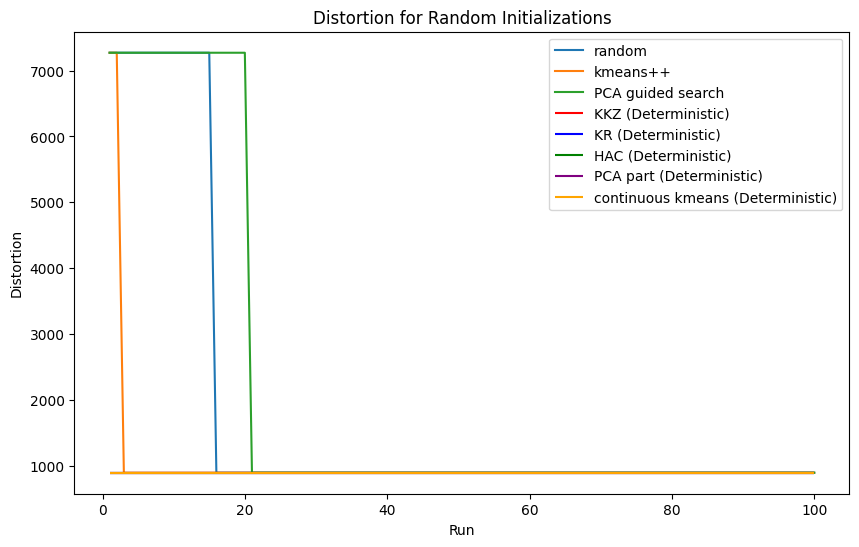

,Initialization,distortion,accuracy,specificity,recall,precision,f1_score,time,runs
0,random,895.794038,1.0,-1.0,1.0,1.0,1.0,0.003371,100
1,kmeans++,895.794038,1.0,-1.0,1.0,1.0,1.0,0.002669,100
2,PCA guided search,895.794038,1.0,-1.0,1.0,1.0,1.0,0.005452,100
3,KKZ,895.794038,1.0,-1.0,1.0,1.0,1.0,0.069554,1
4,KR,895.794038,1.0,-1.0,1.0,1.0,1.0,0.008396,1
5,HAC,895.794038,1.0,-1.0,1.0,1.0,1.0,3.070823,1
6,PCA part,895.794038,1.0,-1.0,1.0,1.0,1.0,0.001968,1
7,continuous kmeans,895.794038,1.0,-1.0,1.0,1.0,1.0,0.401246,1


In [ ]:
# GMM 3 CLUSTERS imputation
random_inits = ["random", "kmeans++", "PCA guided search"]
deterministic_inits = ["KKZ","KR","HAC","PCA part","continuous kmeans"]
X,y = sample_gmm_3_clusters(N)
k = 3
df = scenarios(X,y,k,random_inits,deterministic_inits,100)
df

Init:  random
Init:  kmeans++
Init:  PCA guided search
Init:  KKZ
Init:  KR
Init:  HAC
Init:  PCA part
Init:  continuous kmeans
Computing connected components
Computing spectral ordering
Spectral ordering computed
Initializing valley point detection...
Current prominence 1.0, 2 peaks
Current prominence 1.5, 2 peaks
Current prominence 1.75, 1 peaks
Found K-1 valleys [143]


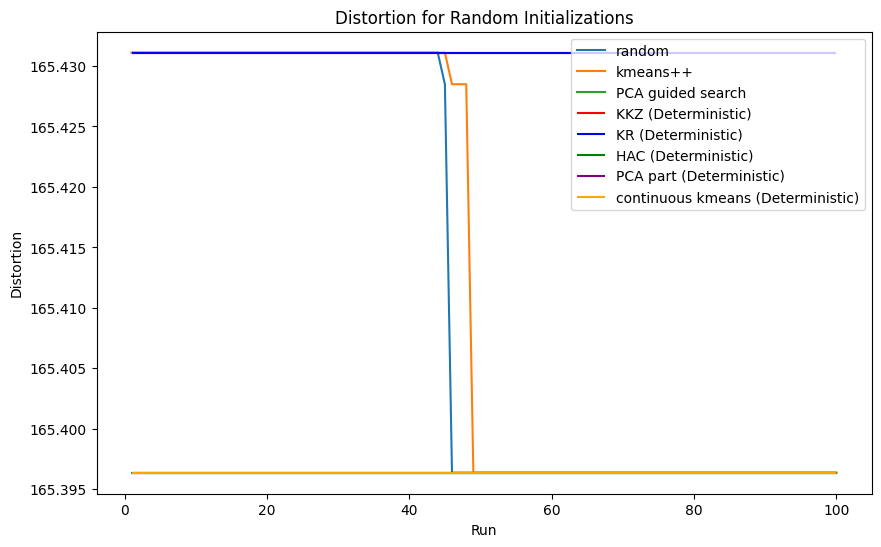

,Initialization,distortion,accuracy,specificity,recall,precision,f1_score,time,runs
0,random,165.396374,0.7475,-1.0,0.7475,0.747804,0.747652,0.001061,100
1,kmeans++,165.396374,0.7475,-1.0,0.7475,0.747804,0.747652,0.001069,100
2,PCA guided search,165.396374,0.7475,-1.0,0.7475,0.747804,0.747652,0.001664,100
3,KKZ,165.431095,0.7475,-1.0,0.7475,0.747556,0.747528,0.007380,1
4,KR,165.431095,0.7475,-1.0,0.7475,0.747556,0.747528,0.002517,1
5,HAC,165.396374,0.7475,-1.0,0.7475,0.747804,0.747652,1.259281,1
6,PCA part,165.396374,0.7475,-1.0,0.7475,0.747804,0.747652,0.001504,1
7,continuous kmeans,165.396374,0.7475,-1.0,0.7475,0.747804,0.747652,0.231347,1


In [ ]:
# 2 MOONS imputation
random_inits = ["random", "kmeans++", "PCA guided search"]
deterministic_inits = ["KKZ","KR","HAC","PCA part","continuous kmeans"]
X,y = sample_moons(N)
k = 2
df = scenarios(X,y,k,random_inits,deterministic_inits,100)
df

Init:  random
Init:  kmeans++
Init:  PCA guided search
Init:  KKZ
Init:  KR
Init:  HAC
Init:  PCA part
Init:  continuous kmeans
Computing connected components
Computing spectral ordering
Spectral ordering computed
Initializing valley point detection...
Current prominence 4.0, 16 peaks
Current prominence 6.0, 5 peaks
Current prominence 5.0, 9 peaks
Found K-1 valleys [ 178  323  353  493  794  977 1196 1504 1628]


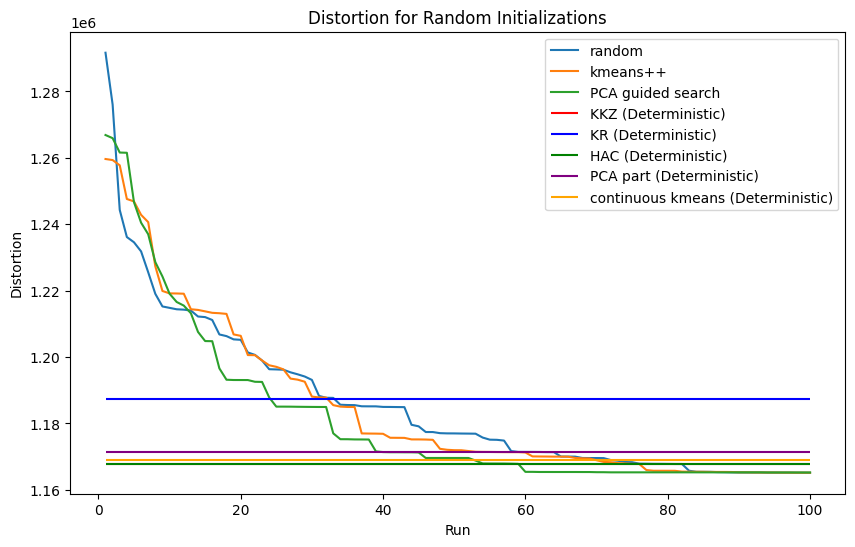

,Initialization,distortion,accuracy,specificity,recall,precision,f1_score,time,runs
0,random,1.165157e+06,0.792988,-1.000038,0.792997,0.803092,0.798012,0.122593,100
1,kmeans++,1.165165e+06,0.793545,-1.000038,0.793558,0.803930,0.798711,0.125551,100
2,PCA guided search,1.165216e+06,0.791875,-1.000036,0.791874,0.800616,0.796221,0.112380,100
3,KKZ,1.167750e+06,0.770173,-0.999972,0.770534,0.783299,0.776864,0.453298,1
4,KR,1.187500e+06,0.713968,-0.999982,0.713837,0.725468,0.719605,0.181937,1
5,HAC,1.167771e+06,0.775181,-0.999972,0.775503,0.786407,0.780917,38.562063,1
6,PCA part,1.171350e+06,0.705064,-1.000008,0.705321,0.711621,0.708457,0.309983,1
7,continuous kmeans,1.168937e+06,0.795771,-1.000024,0.795623,0.796233,0.795928,4.116992,1


In [ ]:
# MNIST imputation
random_inits = ["random", "kmeans++", "PCA guided search"]
deterministic_inits = ["KKZ","KR","HAC","PCA part","continuous kmeans"]
X,y = sample_mnist()
k = 10
df = scenarios(X,y,k,random_inits,deterministic_inits,100)
df

## **Other datasets tested**
In this supplementary section, we investigate additional datasets that were considered during the project's development but were ultimately excluded from the final report due to their limited contributions compared to the selected datasets. While these datasets did not provide significant additional insights, their exploration was instrumental in refining the methodology and informed the decision-making process that led to the final dataset selection.

Init:  random
Init:  kmeans++


<ipython-input-51-4a5a8c2aa40d>:14: RuntimeWarning: divide by zero encountered in divide
  spec = np.sum(true_negatives / negatives) / len(np.unique(y_true))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-51-4a5a8c2aa40d>:14: RuntimeWarning: invalid value encountered in divide
  spec = np.sum(true_negatives / negatives) / len(np.unique(y_true))


Init:  PCA guided search
Init:  KKZ
Init:  KR
Init:  HAC
Init:  PCA part
Init:  continuous kmeans
Computing connected components
Computing spectral ordering
Spectral ordering computed
Initializing valley point detection...
Current prominence 0.5, 5 peaks
Current prominence 0.75, 3 peaks
Current prominence 0.875, 2 peaks
Current prominence 0.9375, 1 peaks
Found K-1 valleys [233]


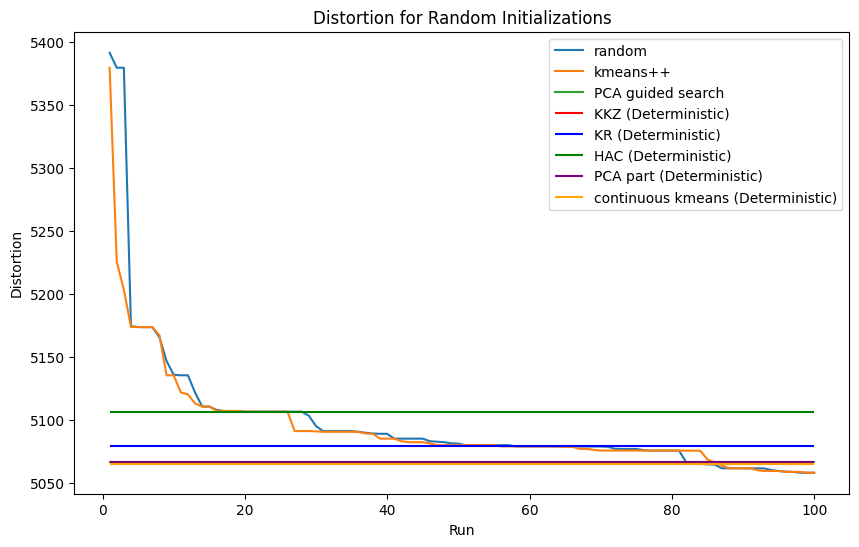

,Initialization,distortion,accuracy,specificity,recall,precision,f1_score,time,runs
0,random,5057.786834,0.500,NaN,0.500,0.500000,0.500000,0.001206,100
1,kmeans++,5057.786834,0.500,NaN,0.500,0.500000,0.500000,0.001328,100
2,PCA guided search,5066.344702,0.500,NaN,0.500,0.500000,0.500000,0.001313,100
3,KKZ,5064.391790,0.500,NaN,0.500,0.500000,0.500000,0.004925,1
4,KR,5078.624301,0.500,NaN,0.500,0.500000,0.500000,0.002299,1
5,HAC,5106.264435,0.500,NaN,0.500,0.500000,0.500000,0.940973,1
6,PCA part,5066.344702,0.500,NaN,0.500,0.500000,0.500000,0.001419,1
7,continuous kmeans,5064.923490,0.505,-1.0,0.505,0.505025,0.505012,0.147136,1


In [ ]:
def sample_sphere(n_samples, r, center=(0, 0, 0), random_state=42):
    rng = np.random.default_rng(random_state)
    theta = np.arccos(1 - 2 * rng.uniform(0, 1, size=n_samples))  # De 0 à π
    phi = 2 * np.pi * rng.uniform(0, 1, size=n_samples)  # De 0 à 2π

    x = r * np.sin(theta) * np.cos(phi) + center[0]
    y = r * np.sin(theta) * np.sin(phi) + center[1]
    z = r * np.cos(theta) + center[2]

    X = np.column_stack((x, y, z))
    return X

def sample_nested_spheres(n_samples, random_state=42):
    sphere1 = sample_sphere(n_samples // 2, 5, (0, 0, 0), random_state)
    sphere2 = sample_sphere(n_samples // 2, 3, (0, 0, 0), random_state)
    X = np.concatenate([sphere1, sphere2])
    y = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))
    return X, y

random_inits = ["random", "kmeans++", "PCA guided search"]
deterministic_inits = ["KKZ","KR","HAC","PCA part","continuous kmeans"]
X,y = sample_nested_spheres(N)
k = 2
df = scenarios(X,y,k,random_inits,deterministic_inits,100)
df

Init:  random
Init:  kmeans++
Init:  PCA guided search


<ipython-input-51-4a5a8c2aa40d>:14: RuntimeWarning: divide by zero encountered in divide
  spec = np.sum(true_negatives / negatives) / len(np.unique(y_true))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-51-4a5a8c2aa40d>:14: RuntimeWarning: invalid value encountered in divide
  spec = np.sum(true_negatives / negatives) / len(np.unique(y_true))


Init:  KKZ
Init:  KR
Init:  HAC
Init:  PCA part
Init:  continuous kmeans
Computing connected components
Computing spectral ordering
Spectral ordering computed
Initializing valley point detection...
Current prominence 0.5, 1 peaks
Found K-1 valleys [205]


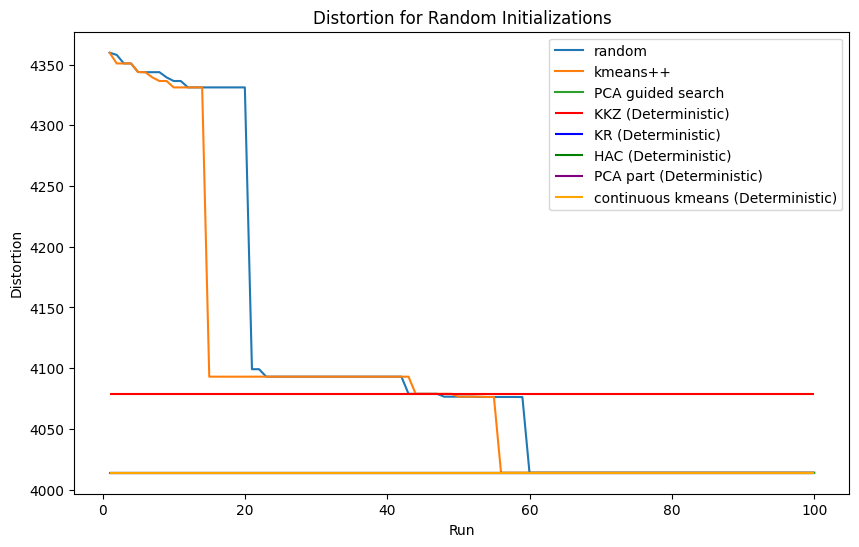

,Initialization,distortion,accuracy,specificity,recall,precision,f1_score,time,runs
0,random,4013.892438,0.5000,NaN,0.5000,0.500000,0.500000,0.000857,100
1,kmeans++,4013.892438,0.5000,NaN,0.5000,0.500000,0.500000,0.000929,100
2,PCA guided search,4013.892438,0.5000,NaN,0.5000,0.500000,0.500000,0.001111,100
3,KKZ,4078.881908,0.5025,-1.0,0.5025,0.502514,0.502507,0.004808,1
4,KR,4013.892438,0.5000,NaN,0.5000,0.500000,0.500000,0.001325,1
5,HAC,4013.892438,0.5000,NaN,0.5000,0.500000,0.500000,0.946071,1
6,PCA part,4013.892438,0.5000,NaN,0.5000,0.500000,0.500000,0.001149,1
7,continuous kmeans,4013.892438,0.5000,NaN,0.5000,0.500000,0.500000,0.150273,1


In [ ]:
def sample_circle(n_samples, r, center=(0, 0), random_state=42):
    rng = np.random.default_rng(random_state)
    v = 2 * np.pi * rng.uniform(0, 1, size=n_samples)
    x = r * np.cos(v) + center[0]
    y = r * np.sin(v) + center[1]
    X = np.transpose([x, y])
    return X

def sample_nested_circles(n_samples, random_state=42):
    circle1 = sample_circle(n_samples // 2, 5, (0, 0), random_state)
    circle2 = sample_circle(n_samples // 2, 3, (0, 0), random_state)
    X = np.concatenate([circle1, circle2])
    y = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))
    return X, y

random_inits = ["random", "kmeans++", "PCA guided search"]
deterministic_inits = ["KKZ","KR","HAC","PCA part","continuous kmeans"]
X,y = sample_nested_circles(N)
k = 2
df = scenarios(X,y,k,random_inits,deterministic_inits,100)
df

Init:  random
Init:  kmeans++
Init:  PCA guided search
Init:  KKZ
Init:  KR
Init:  HAC
Init:  PCA part
Init:  continuous kmeans
Computing connected components
Computing spectral ordering
Spectral ordering computed
Initializing valley point detection...
Current prominence 0.5, 23 peaks
Current prominence 0.25, 33 peaks
Current prominence 0.125, 43 peaks
Current prominence 0.1875, 40 peaks
Current prominence 0.21875, 36 peaks
Current prominence 0.203125, 38 peaks
Current prominence 0.1953125, 38 peaks
Current prominence 0.19140625, 40 peaks
Current prominence 0.193359375, 40 peaks
Current prominence 0.1943359375, 38 peaks
Current prominence 0.19384765625, 39 peaks
Found K-1 valleys [ 11  18  25  36  46  56  67  77  83  92  99 110 116 133 139 149 155 164
 187 193 204 217 225 237 246 258 276 285 296 306 320 331 350 356 367 377
 383 389 394]


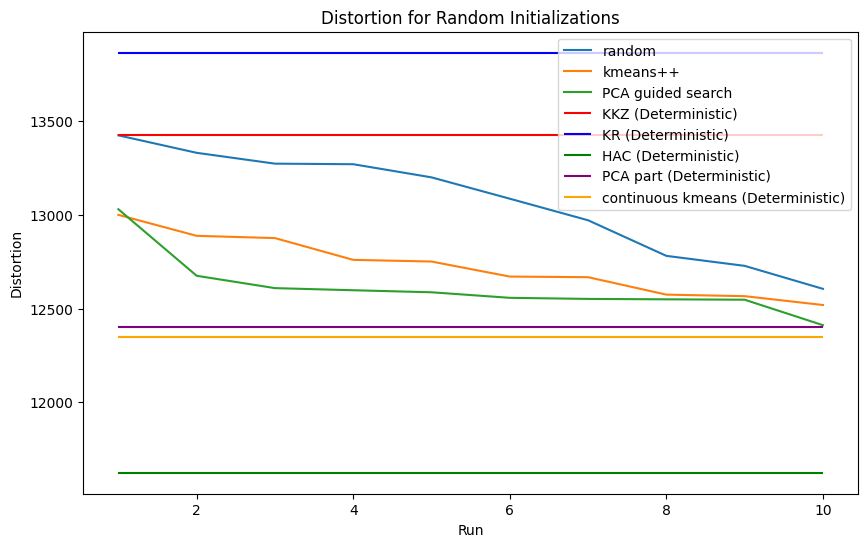

In [ ]:
# Faces imputation
random_inits = ["random", "kmeans++", "PCA guided search"]
deterministic_inits = ["KKZ","KR","HAC","PCA part","continuous kmeans"]
X,y = datasets.fetch_olivetti_faces(return_X_y=True)
k = 40
df = scenarios(X,y,k,random_inits,deterministic_inits,10)

In [ ]:
df

,Initialization,distortion,accuracy,specificity,recall,precision,f1_score,time,runs
0,random,12605.453125,0.5150,-1.0,0.5150,0.593946,0.551663,1.333920,10
1,kmeans++,12519.257812,0.5775,-1.0,0.5775,0.630629,0.602896,1.363896,10
2,PCA guided search,12411.501953,0.5400,-1.0,0.5400,0.605929,0.571068,13.884171,10
3,KKZ,13425.296875,0.4600,-1.0,0.4600,0.496760,0.477674,4.822284,1
4,KR,13866.136719,0.4225,-1.0,0.4225,0.456030,0.438625,6.583431,1
5,HAC,11623.763672,0.6275,-1.0,0.6275,0.676398,0.651032,2.513487,1
6,PCA part,12404.134766,0.5350,-1.0,0.5350,0.574157,0.553887,2.538691,1
7,continuous kmeans,12350.625000,0.6750,-1.0,0.6750,0.713819,0.693867,1.450298,1


## **EM-approch tested**

In this section, we extend our exploration to the Expectation-Maximization (EM) algorithm. Applied to Gaussian Mixture Models (GMMs), EM serves as an effective clustering tool. We evaluated the likelihood on different initializations. The used dataset is a GMM.

In [ ]:
def tau(X, means, covs, alphas):
    n, p = X.shape[0], len(alphas)
    Tau = np.zeros((n, p))


    for j in range(p):
        Tau[:, j] = alphas[j] * scipy.stats.multivariate_normal.pdf(X, means[j], covs[j], allow_singular =True)



    Tau /= Tau.sum(axis=1, keepdims=True)

    return Tau


def Log_likelihood(X, means, covs, alphas):
    '''
    EM Algorithm.
    Inputs:
    - X: Input data of shape (n_samples, n_features).
    - means,covs,alphas: parameters of the mixture

    Outputs:
    - Log-Likelihood
    '''
    n, p = len(X), len(alphas)
    densities = np.array([alphas[j] * scipy.stats.multivariate_normal.pdf(X, means[j], covs[j] + np.eye(covs[j].shape[0]) * 1e-6 , allow_singular =True) for j in range(p)])
    log_likelihood = np.sum(np.log(np.sum(densities, axis=0)))

    return log_likelihood


def initialize_EM_GMM(X, p, init="empirical"):


    init_func = {
      "kmeans++":kmeanspp_init,
      "HAC":HAC_init,
      "PCA guided search":PCA_guided_search_init,
      "KR":kr_init,
      "KKZ":kkz_init,
      "PCA part":PCA_part_init,
      "continuous kmeans": continuous_kmeans_init
    }
    n,d = X.shape[0],X.shape[1]

    # Lazy/Empirical initialization
    if init == "empirical":
        alphas = np.ones(p)/p
        means = X[np.random.randint(0,len(X),p)]
        x_bar = np.mean(X,axis=0)
        sigma2 = np.mean((X-x_bar).T@(X-x_bar))
        covs = sigma2*(np.arange(1,p+1)).reshape(-1,1,1)*np.array(p*[np.eye(d)])

    # Other initializations
    else:
        centroids = init_func[init](X,p)
        labels = np.argmin(np.linalg.norm(X - centroids[:, np.newaxis], axis=2), axis=0)
        means = centroids
        covs = []
        for j in range(p):
            cluster_data = X[labels == j]
            covs.append(np.cov(cluster_data.T))
        covs = np.array(covs)

        alphas = np.array([np.mean(labels == j) for j in range(p)])

    return means, covs, alphas

def EM_GMM(X,p,n_iter=50,eps = 1e-2,verbose=0,init="empirical"):
    '''
    EM Algorithm.
    Inputs:
    - X: Input data of shape (n_samples, n_features).
    - p: number of cluster that should be formed (number of gaussians)

    Outputs:
    - Optimal parameters (means, covariances, weights)
    '''
    means,covs,alphas = initialize_EM_GMM(X, p, init)
    if verbose == 1: print("Init:", means,covs,alphas)
    it = 0
    n,d= len(X),X.shape[1]
    L = Log_likelihood(X, means, covs, alphas)
    L_list = [L]
    if verbose == 1: print(f"Iteration {it}: Log-likelihood value = {L}")
    while (it < n_iter):
        it += 1

        #Step E
        Tau = tau(X, means, covs, alphas)

        #Step M
        nc= np.sum(Tau,axis=0)

        alphas = np.mean(Tau,axis=0) #size p

        means = np.dot(Tau.T, X)/nc.reshape(-1,1) #size p

        for j in range(p):
            covs[j] = sum([Tau[i,j]*np.outer(X[i]-means[j], X[i]-means[j]) for i in range(n)])/nc[j]


        L = Log_likelihood(X, means, covs, alphas)

        if np.abs(L-L_list[-1]) < eps:
            L_list.append(L)
            if verbose == 1: print(f"Stop: Variation < {eps}")
            break

        L_list.append(L)

        if verbose == 1: print(f"Iteration {it}: Log-likelihood value = {L}")


    return alphas,means,covs,L_list


In [ ]:
def GMM_EM_eval(X,p,random_inits,deterministic_inits,n_runs):
    results = {}
    # Testing random initializations
    for init_name in random_inits:
        print("Init: ", init_name)
        max_log = -float('inf')
        total_time = 0
        for _ in range(n_runs):
            start_time = time.time()
            _,_,_,L_list = EM_GMM(X,p,n_iter=100,eps=1e-6,verbose=0,init=init_name)
            log_likelihood = L_list[-1]
            total_time += time.time() - start_time

            if log_likelihood > max_log:
                max_log = log_likelihood


        results[init_name] = {'Log likelihood': max_log, 'avg_time': total_time / n_runs}

    # Testing deterministic initializations
    for init_name in deterministic_inits:
        print("Init: ", init_name)
        start_time = time.time()
        _,_,_,L_list = EM_GMM(X,p,n_iter=100,eps=1e-6,verbose=0,init = init_name)
        log_likelihood = L_list[-1]

        total_time = time.time() - start_time
        results[init_name] = {'Log likelihood': log_likelihood, 'time': total_time}

    # Convert results to pandas DataFrame and display
    df_results = pd.DataFrame.from_dict(results, orient='index')
    df_results['time'] = df_results['avg_time'].fillna(df_results['time'])
    df_results.drop(columns='avg_time', inplace=True)
    df_results['runs'] = n_runs  # Number of runs for random initializations
    df_results.loc[deterministic_inits, 'runs'] = 1  # Override for deterministic initializations
    df_results.reset_index(inplace=True)
    df_results.rename(columns={'index': 'Initialization'}, inplace=True)

    return df_results

In [ ]:
def sample_gmm_2_overlapping(n_samples, random_state=42):
    means = [[0, 0], [1, 1]]
    covs = [np.eye(2), np.eye(2)]
    probs = [0.5, 0.5]
    return sample_GMM(n_samples, 2, means, covs, probs, random_state)

N2 = 1000
X,y = sample_gmm_2_overlapping(N2)
random_inits = ["empirical","kmeans++", "PCA guided search"]
deterministic_inits = ["KKZ","KR","HAC","PCA part","continuous kmeans"]
GMM_EM_eval(X,2,random_inits,deterministic_inits,10)